## Assessment 2: Churn Prediction

Can you predict whether a customer will churn or not?

Understanding Problem Statement

Decreasing the Customer Churn is a key goal for any business. Predicting Customer Churn (also known as Customer Attrition) represents an additional potential revenue source for any business. Customer Churn impacts the cost to the business. Higher Customer Churn leads to loss in revenue and the additional marketing costs involved with replacing those customers with new ones. 

In this challenge, as a data scientist of a bank, you are asked to analyze the past data and predict whether the customer will churn or not in the next 6 months. This would help the bank to have the right engagement with customers at the right time.

## Objective

Our objective is to build a machine learning model to predict whether the customer will churn or not in the next six months.





In [96]:
#Loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from pandas import to_datetime
import itertools
import warnings
import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [97]:
# load data- Train Set
df = pd.read_csv("train.csv")
df.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [98]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,6650.0,41.130226,9.685747,21.0,34.0000,40.000,47.00,72.00
Balance,6650.0,804595.354985,515754.867315,63.0,392264.2125,764938.575,1147123.71,2436615.81
Vintage,6650.0,2.250226,1.458795,0.0,1.0000,2.000,3.00,5.00
Transaction_Status,6650.0,0.515789,0.499788,0.0,0.0000,1.000,1.00,1.00
Credit_Card,6650.0,0.664361,0.472249,0.0,0.0000,1.000,1.00,1.00
Is_Churn,6650.0,0.231128,0.421586,0.0,0.0000,0.000,0.00,1.00


In [99]:
import plotly.graph_objects as go
colors = ['gold', 'mediumturquoise']
labels = ['Not Churn','Churn']
values = df['Is_Churn'].value_counts()/df['Is_Churn'].shape[0]
fig = go.Figure(data=[go.Pie(labels = labels,
                             values=values,hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="Churn",
)
fig.show()


## No Null Values

In [100]:
df.isnull().sum()

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [101]:
df.shape

(6650, 11)

In [102]:
df_2 = df.copy()
df_2.drop("ID",axis=1, inplace=True)
df_2.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [103]:
df_2.dtypes

Age                     int64
Gender                 object
Income                 object
Balance               float64
Vintage                 int64
Transaction_Status      int64
Product_Holdings       object
Credit_Card             int64
Credit_Category        object
Is_Churn                int64
dtype: object

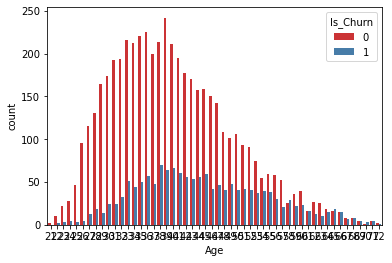

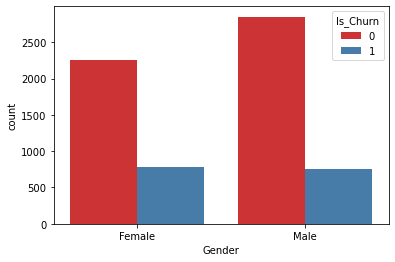

In [104]:
# Investigate all the features by our y

features = ['Age', 'Gender']


for f in features:
    plt.figure()
    ax = sns.countplot(x=f, data=df_2, hue = 'Is_Churn', palette="Set1")

Text(0.5, 1.0, 'Income Vs Churn')

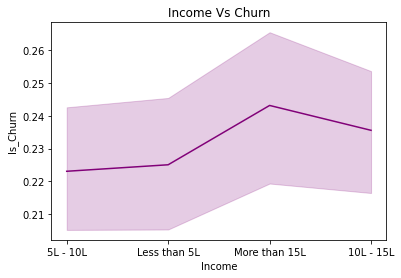

In [105]:
sns.set_palette(palette='RdPu_r')
sns.lineplot('Income','Is_Churn', data=df, alpha=1.0)
plt.title('Income Vs Churn')
#plt.savefig('');

Text(0.5, 1.0, 'Age Vs Churn')

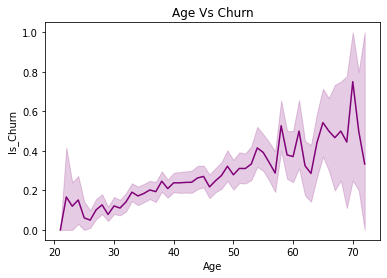

In [106]:
sns.set_palette(palette='RdPu_r')
sns.lineplot('Age','Is_Churn', data=df, alpha=1.0)
plt.title('Age Vs Churn')

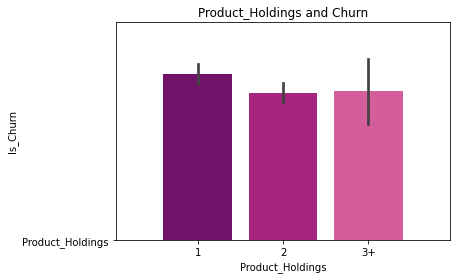

In [107]:
sns.set_palette(palette='RdPu_r')
sns.barplot('Product_Holdings','Is_Churn', data=df)
y = [0,1]
labels = ['Product_Holdings', 'Is_Churn']
plt.yticks(y, labels)
plt.margins(0.2)
plt.title('Product_Holdings and Churn')
plt.show()

In [108]:
df_2["Product_Holdings"].replace({"+3": 3,"3+":3}, inplace=True)
df_2["Product_Holdings"].value_counts()

1    3200
2    3182
3     268
Name: Product_Holdings, dtype: int64

In [109]:
df_2["Product_Holdings"] = df_2["Product_Holdings"].astype('int')

In [110]:
df_2["Gender"].value_counts()

Male      3612
Female    3038
Name: Gender, dtype: int64

In [111]:
df_2["Income"].value_counts()

10L - 15L        1885
5L - 10L         1847
Less than 5L     1573
More than 15L    1345
Name: Income, dtype: int64

In [112]:
df_2["Credit_Category"].value_counts()

Poor       3076
Average    2043
Good       1531
Name: Credit_Category, dtype: int64

### Using Get Dummied and Dropping first to avoid dummies trap

In [113]:
df_changed = pd.get_dummies(data=df_2,columns=["Gender","Income","Credit_Category"],drop_first=True)
df_changed.head()

,Age,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Is_Churn,Gender_Male,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Credit_Category_Good,Credit_Category_Poor
0,36,563266.44,4,0,1,0,1,0,1,0,0,0,0
1,53,875572.11,2,1,1,1,0,0,0,1,0,0,1
2,35,701607.06,2,1,2,0,0,0,0,0,1,0,1
3,43,1393922.16,0,1,2,1,1,0,0,0,1,0,1
4,39,893146.23,1,1,1,1,1,0,0,0,1,1,0


In [114]:
X = df_changed.drop('Is_Churn', axis= 1)
y = df_changed.Is_Churn

In [115]:
y.value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="minority") 
X_sm,y_sm = smote.fit_resample(X,y)

y_sm.value_counts()

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=  0.2, random_state=30)


print("X train:",X_train.shape)
print("X test:",X_test.shape)
print("y train:",y_train.shape)
print("y test:",y_test.shape)

X train: (5320, 12)
X test: (1330, 12)
y train: (5320,)
y test: (1330,)


from collections import Counter

from imblearn.combine import SMOTETomek

from collections import Counter
Counter(y_train)

os=SMOTETomek(0.75)
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

In [117]:
## Scaling for train

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_train.head()

,Age,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Gender_Male,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Credit_Category_Good,Credit_Category_Poor
0,0.215686,0.302762,0.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.980392,0.419775,0.8,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.588235,0.385324,0.6,1.0,0.5,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.372549,0.369109,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.254902,0.354825,0.2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [118]:
## Scaling for Test

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_test=pd.DataFrame(scaler.fit_transform(X_test),columns=X_test.columns)
X_test.head()

,Age,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Gender_Male,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Credit_Category_Good,Credit_Category_Poor
0,0.224490,0.077810,0.4,1.0,0.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.244898,0.432062,0.8,0.0,0.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.714286,0.328423,0.6,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.306122,0.066078,0.4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.612245,0.651157,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## DISTRIBUTION

## Outliers RMOVING

In [119]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error

In [120]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.07)
yhat = iso.fit_predict(X_train)

In [121]:
# select all rows that are not outliers
mask = yhat != -1

X_train = X_train[mask]
y_train = y_train[mask]

In [122]:
print(X_train.shape, y_train.shape)

(4947, 12) (4947,)


In [123]:
## Collinearity

In [124]:
X_train.corr()

,Age,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Gender_Male,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Credit_Category_Good,Credit_Category_Poor
Age,1.000000,-0.001786,0.022509,0.031088,-0.028593,0.028677,0.014339,0.001556,-0.032645,0.000890,-0.033652,0.021247
Balance,-0.001786,1.000000,-0.014973,-0.009735,-0.247770,-0.011383,0.015463,-0.045817,-0.024399,0.034434,-0.045638,0.005300
Vintage,0.022509,-0.014973,1.000000,-0.026919,0.025223,0.007818,-0.015459,0.010106,-0.022408,-0.010924,0.029729,-0.008369
Transaction_Status,0.031088,-0.009735,-0.026919,1.000000,-0.000880,0.005922,0.003819,-0.019738,-0.008675,-0.001583,0.038764,-0.026245
Product_Holdings,-0.028593,-0.247770,0.025223,-0.000880,1.000000,0.013748,-0.029686,0.022386,-0.017395,-0.005927,-0.005138,0.000090
Credit_Card,0.028677,-0.011383,0.007818,0.005922,0.013748,1.000000,-0.022707,0.009384,0.004645,0.019365,0.036387,-0.038717
Gender_Male,0.014339,0.015463,-0.015459,0.003819,-0.029686,-0.022707,1.000000,0.006314,0.014391,-0.010974,0.021253,-0.007029
Income_5L - 10L,0.001556,-0.045817,0.010106,-0.019738,0.022386,0.009384,0.006314,1.000000,-0.333295,-0.301780,0.002406,0.015152
Income_Less than 5L,-0.032645,-0.024399,-0.022408,-0.008675,-0.017395,0.004645,0.014391,-0.333295,1.000000,-0.257389,-0.034559,0.023037
Income_More than 15L,0.000890,0.034434,-0.010924,-0.001583,-0.005927,0.019365,-0.010974,-0.301780,-0.257389,1.000000,-0.001606,-0.004599


<AxesSubplot:>

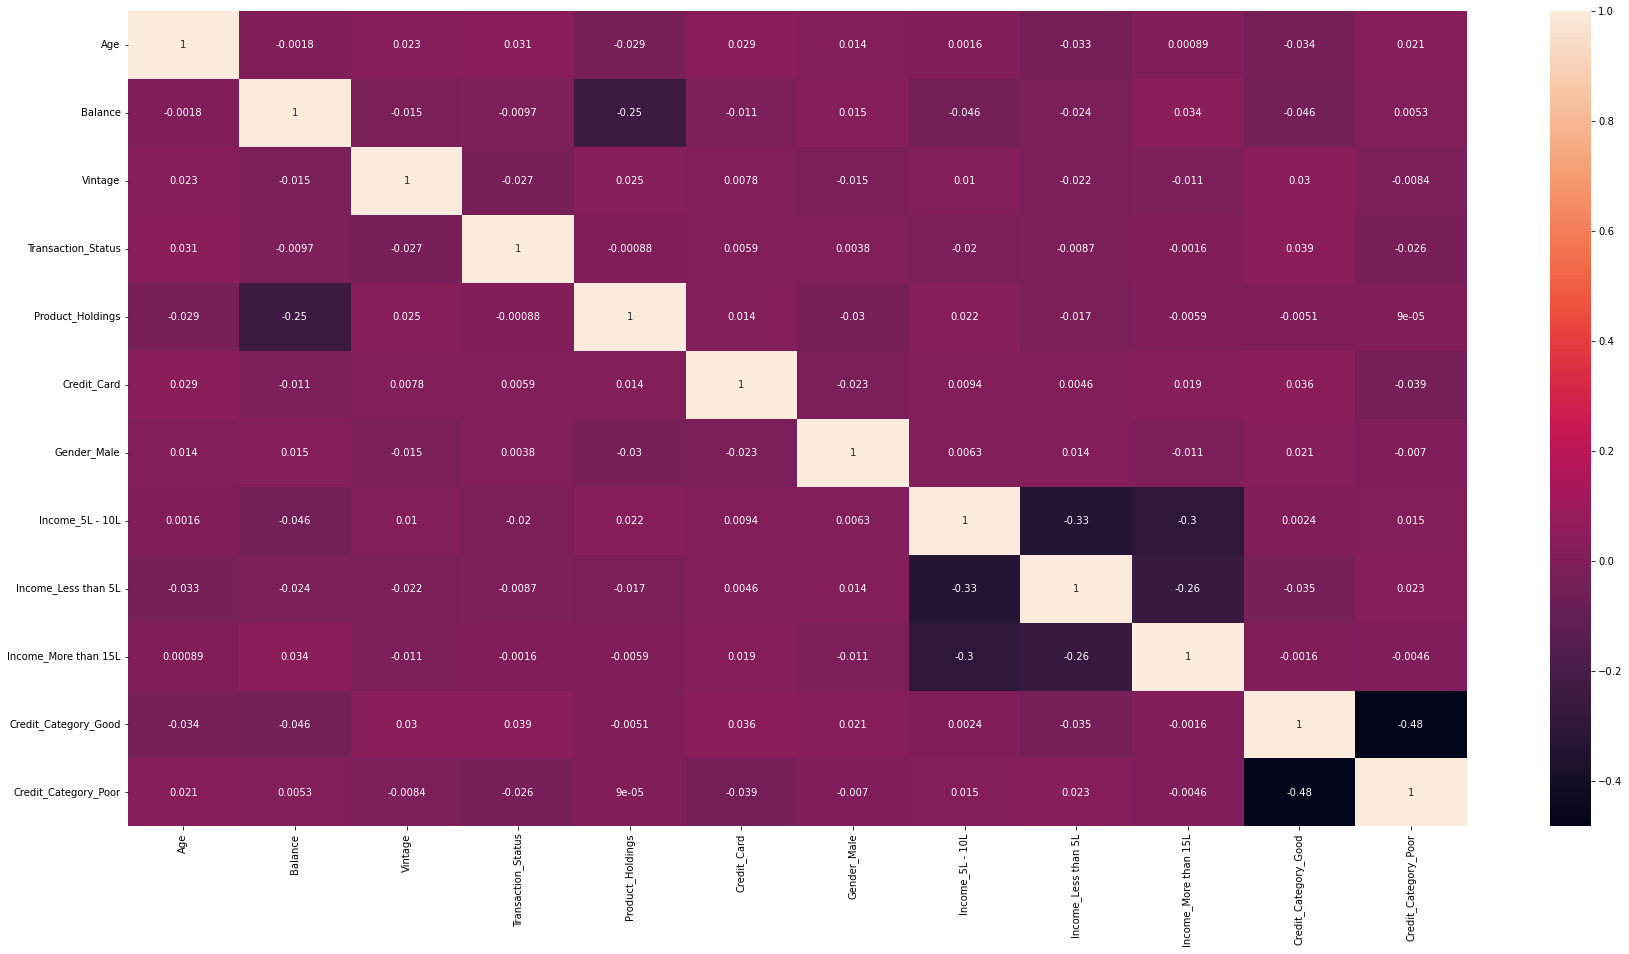

In [125]:
import seaborn as sns
corr=X_train.corr()
top_features=corr.index
plt.figure(figsize=(30,15))
sns.heatmap(X_train[top_features].corr(),annot=True)

In [126]:
threshold=0.6

# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [127]:
correlation(X_train, threshold)

set()

In [128]:
print(X_train.shape, y_train.shape)

(4947, 12) (4947,)


In [129]:
## Information Gain

In [130]:
from sklearn.feature_selection import mutual_info_classif
mutual_info=mutual_info_classif(X_train,y_train)
mutual_data=pd.Series(mutual_info,index=X_train.columns)
mutual_data.sort_values(ascending=False)

Age                     0.023444
Gender_Male             0.013062
Transaction_Status      0.011846
Product_Holdings        0.004094
Income_5L - 10L         0.002747
Balance                 0.001576
Credit_Category_Poor    0.000810
Credit_Category_Good    0.000000
Income_More than 15L    0.000000
Income_Less than 5L     0.000000
Credit_Card             0.000000
Vintage                 0.000000
dtype: float64

From the above Information, <br>
We will be `ignorning` the feature variable with No `Information Gain` <br>
<br>
Credit_Category_Poor    0.000000

Income_Less than 5L     0.000000

Income_5L - 10L         0.000000

Vintage                 0.000000

Balance                 0.000000


In [131]:
X_train = X_train.drop(columns = ['Credit_Category_Poor','Income_Less than 5L','Income_5L - 10L',
                                 'Vintage','Balance'])

In [132]:
X_train

,Age,Transaction_Status,Product_Holdings,Credit_Card,Gender_Male,Income_More than 15L,Credit_Category_Good
0,0.215686,1.0,0.5,0.0,1.0,0.0,1.0
2,0.588235,1.0,0.5,0.0,1.0,0.0,0.0
3,0.372549,0.0,0.0,0.0,1.0,0.0,0.0
4,0.254902,0.0,0.0,1.0,1.0,0.0,0.0
5,0.529412,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
5314,0.588235,1.0,0.0,0.0,0.0,0.0,0.0
5316,0.862745,1.0,0.0,1.0,1.0,0.0,0.0
5317,0.549020,1.0,0.5,1.0,0.0,0.0,1.0
5318,0.333333,1.0,0.0,1.0,1.0,0.0,0.0


In [133]:
X_test = X_test.drop(columns = ['Credit_Category_Poor','Income_Less than 5L','Income_5L - 10L',
                                 'Vintage','Balance'])

In [134]:
print(X_train.shape, y_train.shape)

(4947, 7) (4947,)


In [135]:
y_train.value_counts()

0    3820
1    1127
Name: Is_Churn, dtype: int64

# handling Imbalance

In [136]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="minority") 
X_train,y_train = smote.fit_resample(X_train,y_train)

y_train.value_counts()

1    3820
0    3820
Name: Is_Churn, dtype: int64

In [137]:
train_df =pd.concat([X_train,y_train],axis=1)
colors = ['gold', 'mediumturquoise']
labels = ['Not Churn','Is_Churn']
values = train_df['Is_Churn'].value_counts()/train_df['Is_Churn'].shape[0]
fig = go.Figure(data=[go.Pie(labels = labels,
                             values=values,hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Is_Churn",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

# XGBOOST

In [138]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost

classifier=xgboost.XGBClassifier(tree_method='gpu_hist')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=2,random_state=30)

clf.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=3, max_depth=15, learning_rate=0.3, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=1, max_depth=15, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3 
[CV]  min_child_weight=1, max_depth=15, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3, total=   0.6s
[CV] min_child_weight=1, max_depth=15, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3 
[CV]  min_child

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.7s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           scale_pos_weight=None,
                                           subsample=None,
                                           tree_method='

In [139]:
clf.best_params_

{'min_child_weight': 7,
 'max_depth': 2,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

In [140]:
clf.best_score_

0.646265062696754

In [141]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=2,
              min_child_weight=7, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [142]:
model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=30,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [143]:
from sklearn.metrics import confusion_matrix, classification_report
pred_xgboost = model.predict(X_test)
pred_xgboost
confusion_matrix(y_test, pred_xgboost)

print("Classification Report : ", classification_report(y_test, pred_xgboost))

Classification Report :                precision    recall  f1-score   support

           0       0.80      0.12      0.20      1019
           1       0.24      0.90      0.38       311

    accuracy                           0.30      1330
   macro avg       0.52      0.51      0.29      1330
weighted avg       0.67      0.30      0.24      1330



# ========================================

# -- TEST

In [144]:
## On Test Data

df_test = pd.read_csv("test.csv")
df_test.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category
0,55480787,50,Female,More than 15L,1008636.39,2,1,2,1,Average
1,9aededf2,36,Male,5L - 10L,341460.72,2,0,2,1,Average
2,a5034a09,25,Female,10L - 15L,439460.10,0,0,2,1,Good
3,b3256702,41,Male,Less than 5L,28581.93,0,1,2,1,Poor
4,dc28adb5,48,Male,More than 15L,1104540.03,2,1,3+,0,Good


In [145]:
df_test2 = df_test.copy()

In [146]:
df_test2["Product_Holdings"].replace({"+3": 3,"3+":3}, inplace=True)
df_test2["Product_Holdings"].value_counts()

2    1359
1    1342
3     150
Name: Product_Holdings, dtype: int64

In [147]:
df_test2.drop("ID",axis=1, inplace=True)

In [148]:
df_test2_changed = pd.get_dummies(data=df_test2,columns=["Gender","Income","Credit_Category"],drop_first=True)
df_test2_changed.head()

,Age,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Gender_Male,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Credit_Category_Good,Credit_Category_Poor
0,50,1008636.39,2,1,2,1,0,0,0,1,0,0
1,36,341460.72,2,0,2,1,1,1,0,0,0,0
2,25,439460.10,0,0,2,1,0,0,0,0,1,0
3,41,28581.93,0,1,2,1,1,0,1,0,0,1
4,48,1104540.03,2,1,3,0,1,0,0,1,1,0


In [149]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df_test2_changed=pd.DataFrame(scaler.fit_transform(df_test2_changed),columns=df_test2_changed.columns)
df_test2_changed.head()

,Age,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Gender_Male,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Credit_Category_Good,Credit_Category_Poor
0,0.568627,0.413891,0.4,1.0,0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.294118,0.139709,0.4,0.0,0.5,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.078431,0.179983,0.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.392157,0.011128,0.0,1.0,0.5,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.529412,0.453303,0.4,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [150]:
df_test2_changed = df_test2_changed.drop(columns = ['Credit_Category_Poor','Income_Less than 5L','Income_5L - 10L',
                                 'Vintage','Balance'])

In [151]:
df_test2_changed.dtypes

Age                     float64
Transaction_Status      float64
Product_Holdings        float64
Credit_Card             float64
Gender_Male             float64
Income_More than 15L    float64
Credit_Category_Good    float64
dtype: object

In [152]:
X_test_final = df_test2_changed
X_test_final

,Age,Transaction_Status,Product_Holdings,Credit_Card,Gender_Male,Income_More than 15L,Credit_Category_Good
0,0.568627,1.0,0.5,1.0,0.0,1.0,0.0
1,0.294118,0.0,0.5,1.0,1.0,0.0,0.0
2,0.078431,0.0,0.5,1.0,0.0,0.0,1.0
3,0.392157,1.0,0.5,1.0,1.0,0.0,0.0
4,0.529412,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
2846,0.372549,0.0,0.0,1.0,0.0,0.0,0.0
2847,0.529412,1.0,0.5,1.0,0.0,1.0,0.0
2848,0.745098,0.0,0.0,1.0,1.0,1.0,0.0
2849,0.254902,0.0,0.0,1.0,0.0,0.0,0.0


In [153]:
pred_xgboost_test = model.predict(X_test_final)
pred_xgboost_test

array([0, 0, 0, ..., 1, 0, 1])

rf_tuned_predict = rf_tuned.predict(X_test_final)
rf_tuned_predict

In [154]:
final = pd.DataFrame(data=pred_xgboost_test,columns=["Is_Churn"])
final

,Is_Churn
0,0
1,0
2,0
3,0
4,0
...,...
2846,1
2847,1
2848,1
2849,0


In [155]:
df_test_1 = df_test.copy()
df_test_1.drop(["Age","Gender","Income","Balance","Vintage","Transaction_Status","Product_Holdings","Credit_Card","Credit_Category"],axis=1,inplace=True)

In [156]:
det = pd.concat([df_test_1, final], join = 'outer', axis = 1)

In [157]:
det

,ID,Is_Churn
0,55480787,0
1,9aededf2,0
2,a5034a09,0
3,b3256702,0
4,dc28adb5,0
...,...,...
2846,19e40adf,1
2847,52d5bc8d,1
2848,f708121b,1
2849,f008715d,0


In [158]:
det.to_csv("refe.csv",index=False)

lol.to_csv("22.csv",index=False)